In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
from PIL import Image
from scipy import optimize
from scipy.special import ellipkinc
from scipy.optimize import fsolve

class SchwarzschildRayTracer:
    def __init__(self, bh_mass=1.0, image_size_x=700, image_size_y=700):

        self.image_size_x = image_size_x
        self.image_size_y = image_size_y

        self.bh_mass = bh_mass
        self.rs = 2 * bh_mass  # Radio de Schwarzschild
        self.r_start = 400 * self.rs
        self.b_max_x = 40*self.rs
        self.b_max_y = self.b_max_x/image_size_x*image_size_y
        self.b_max = np.sqrt(self.b_max_x**2+self.b_max_y**2)
        self.r_max = self.r_start*1.1
        self.image = np.zeros((image_size_y, image_size_x, 3), dtype=np.uint8)  # RGB
        
        self.stars_img = np.array(Image.open("../data/Background_1.jpg").convert('RGB'))

        self.stars_height, self.stars_width = self.stars_img.shape[:2]
        print(self.stars_height, self.stars_width)

    def equation(self, phi, y, b):
        # y = [r, dr/dphi]
        r, dr_dphi = y
        f = 1 - self.rs / r
        d2r_dphi2 = (f * (self.r_start**2 / b**2) - f * (dr_dphi**2) / r - f * r)
        return [dr_dphi, d2r_dphi2]
    
    

    def trace_ray(self, b, theta_view):
        phi= b / self.b_max * np.pi   #[0,pi]

        def colour(phi, theta_view, alpha):
            phi = (phi/25-np.pi/50)*self.b_max_x/10 *self.rs #[-pi/20,pi/20]

            x = ((np.sin(phi-(alpha)) * np.cos(theta_view))/(np.pi)+1)/2 #[0,1]
            y = ((np.sin(phi-(alpha)) * np.sin(theta_view))/(np.pi)+1)/2 #[0,1]
            z = np.cos((phi-alpha)) #[0,1]

            i = int(x * self.stars_width) % self.stars_width #[0, 1, ..., self.stars_width]
            j = int(y * self.stars_height) % self.stars_height

            return self.stars_img[j,i]
            
        def f_rm(b):
            def rmin(R, b):
                return 1 / b**2 - 1 / R**2 + self.rs / R**3
            r_min = self.rs * 3/2
            r_max = self.r_max
            fa = rmin(r_min, b)
            fb = rmin(r_max, b)

            if fa * fb >= 0:
                return 0
            else:
                sol = optimize.root_scalar(rmin, bracket=[r_min, r_max], args=(b,), method='brentq')
                rm = sol.root
                return rm

        def deflexion(rm):
            s=np.sqrt((rm-self.rs)*(rm+3*self.rs))
            m=(s-rm+3*self.rs)/2/s
            arg=np.sqrt(2*s/(3*rm-3*self.rs+s))
            arg = np.clip(arg, -1.0, 1.0)
            varphi=np.arcsin(arg)

            alpha=(4*np.sqrt(rm/s)*float(ellipkinc(varphi, m)) % (2 * np.pi) ) -np.pi  #[-pi, pi]
            return alpha
        
        if b<=self.rs:
            return [0, 0, 0]  # Evitar errores numericos de division por 0 y es evidente que caen al agujero. 
        
        rm=f_rm(b)
        alpha = deflexion(rm)

        if np.isnan(alpha):
            return [0,0,0]
        else:
            return colour(phi, theta_view, alpha)
        
    def render(self):
        
        b_max_x = self.b_max_x
        b_max_y = self.b_max_y
        d=np.sqrt(self.image_size_x**2/self.image_size_y**2+1)
        with tqdm(total=self.image_size_y, desc="Renderizando", unit="px") as pbar:

            for i in range(self.image_size_y):
                for j in range(self.image_size_x):

                    x = (j - self.image_size_x / 2) / (self.image_size_x / 2) * b_max_x
                    y = (i - self.image_size_y / 2) / (self.image_size_y / 2) * b_max_y
                    
                    theta_view = np.arctan2(y, x)
                    b = np.sqrt(x**2 + y**2)

                    A= ((self.rs*np.cos(theta_view) - 2 * b_max_x / (self.image_size_x / 2) < x) and (x<self.rs*np.cos(theta_view) + 2 * b_max_x / (self.image_size_x / 2) ))
                    B= ((self.rs*np.sin(theta_view) - 2 * b_max_y / (self.image_size_y / 2) < y) and (y<self.rs*np.sin(theta_view) + 2 * b_max_y / (self.image_size_y / 2) ))

                    if A and B :
                        self.image[i, j] = [255,0,0]
                        #print("red")
                    else:
                        theta_view = np.arctan2(y, x)
                        color = self.trace_ray(b, theta_view)
                        self.image[i, j] = color
                pbar.update(1)


        plt.imshow(self.image, cmap='gray', origin='lower')
        #plt.title("Sombra del agujero negro (modelo simple)")
        plt.axis('off')
        #plt.show()
        plt.savefig("../Multimedia/Agujero_negro/Sombra del agujero negro.png")

rt = SchwarzschildRayTracer(image_size_x=600, image_size_y=350, bh_mass=1.0)
rt.render() # máximo parámetro de impacto

1620 3240


Renderizando: 100%|██████████| 350/350 [00:36<00:00,  9.64px/s]


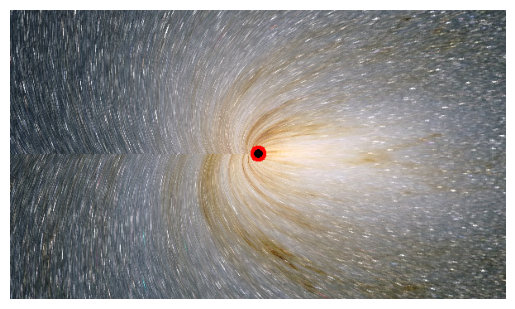

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
from PIL import Image
from scipy import optimize
from scipy.special import ellipkinc
from scipy.optimize import fsolve

class SchwarzschildRayTracer:
    def __init__(self, bh_mass=1.0, image_size_x=700, image_size_y=700):

        self.image_size_x = image_size_x
        self.image_size_y = image_size_y

        self.bh_mass = bh_mass
        self.rs = 2 * bh_mass  # Radio de Schwarzschild
        self.r_start = 200 * self.rs
        self.b_max_x = 40*self.rs
        self.b_max_y = self.b_max_x/image_size_x*image_size_y
        self.b_max = np.sqrt(self.b_max_x**2+self.b_max_y**2)
        self.r_max = self.r_start*1.1
        self.image = np.zeros((image_size_y, image_size_x, 3), dtype=np.uint8)  # RGB
        
        self.stars_img = np.array(Image.open("../data/Background_1.jpg").convert('RGB'))

        self.stars_height, self.stars_width = self.stars_img.shape[:2]
        print(self.stars_height, self.stars_width)

    def equation(self, phi, y, b):
        # y = [r, dr/dphi]
        r, dr_dphi = y
        f = 1 - self.rs / r
        d2r_dphi2 = (f * (self.r_start**2 / b**2) - f * (dr_dphi**2) / r - f * r)
        return [dr_dphi, d2r_dphi2]
    
    def trace_ray(self, b, theta_view):
        phi= np.arcsin(b / np.sqrt(b**2+self.r_start**2))    #[0,pi]
        #phi_max= np.arcsin(self.b_max / np.sqrt(self.b_max**2+self.r_start**2))

        def cartesian_to_spherical(x, y, z):
            r = np.sqrt(x**2 + y**2 + z**2)
            theta = np.arccos(z / r)        # colatitud [0, π]
            phi = np.arctan2(y, x)          # longitud [-π, π]
            return r, theta, phi

        def spherical_to_mollweide(theta, phi):
            # Convert colatitude to latitude
            lat = np.pi/2 - theta  # [−π/2, π/2]

            # Mollweide projection parameters
            def equation(theta_p):
                return 2 * theta_p + np.sin(2 * theta_p) - np.pi * np.sin(lat)

            theta_p_initial_guess = lat
            theta_p = fsolve(equation, theta_p_initial_guess)[0]

            x = 0.999 / np.pi * phi * np.cos(theta_p)+0.5
            y = 0.999 * np.sin(theta_p)+0.5
            return x, y
        
        def colour(phi, theta_view, alpha):
            #phi = (phi-phi_max/2) #[-pi/20,pi/20]

            x = (np.sin(phi+alpha) * np.cos(theta_view)) #[0,1]
            y = (np.sin(phi+alpha) * np.sin(theta_view)) #[0,1]
            z = np.cos((phi+alpha)) #[0,1]

            _, theta1, phi1=cartesian_to_spherical(x, y, z)
            x,y=spherical_to_mollweide(theta1, phi1)

            i = int(x * self.stars_width) % self.stars_width #[0, 1, ..., self.stars_width]
            j = int(y * self.stars_height) % self.stars_height

            return self.stars_img[j, i]
            
        def f_rm(b):
            def rmin(R, b):
                return 1 / b**2 - 1 / R**2 + self.rs / R**3
            
            r_min = self.rs * 3/2
            r_max = self.r_max
            fa = rmin(r_min, b)
            fb = rmin(r_max, b)

            if fa * fb >= 0:
                return 0
            else:
                sol = optimize.root_scalar(rmin, bracket=[r_min, r_max], args=(b,), method='brentq')
                rm = sol.root
                return rm

        def deflexion(rm):
            s=np.sqrt((rm-self.rs)*(rm+3*self.rs))
            m=(s-rm+3*self.rs)/2/s
            arg=np.sqrt(2*s/(3*rm-3*self.rs+s))
            arg = np.clip(arg, -1.0, 1.0)
            varphi=np.arcsin(arg)

            alpha=(4*np.sqrt(rm/s)*float(ellipkinc(varphi, m)) % (2 * np.pi) ) -np.pi  #[-pi, pi]
            return alpha
        
        if b<=1.001*self.rs:
            return [0, 0, 0]  # Evitar errores numericos de division por 0 y es evidente que caen al agujero. 
        
        rm=f_rm(b)
        #alpha = deflexion(rm)
        alpha=0
        if np.isnan(alpha):
            return [0,0,0]
        else:
            return colour(phi, theta_view, alpha)


    def render(self):
        
        b_max_x = self.b_max_x
        b_max_y = self.b_max_y
        d=np.sqrt(self.image_size_x**2/self.image_size_y**2+1)
        with tqdm(total=self.image_size_y, desc="Renderizando", unit="px") as pbar:

            for i in range(self.image_size_y):
                for j in range(self.image_size_x):

                    x = (j - self.image_size_x / 2) / (self.image_size_x / 2) * b_max_x
                    y = (i - self.image_size_y / 2) / (self.image_size_y / 2) * b_max_y
                    
                    theta_view = np.arctan2(y, x)
                    b = np.sqrt(x**2 + y**2)

                    A= ((self.rs*np.cos(theta_view) - 2 * b_max_x / (self.image_size_x / 2) < x) and (x<self.rs*np.cos(theta_view) + 2 * b_max_x / (self.image_size_x / 2) ))
                    B= ((self.rs*np.sin(theta_view) - 2 * b_max_y / (self.image_size_y / 2) < y) and (y<self.rs*np.sin(theta_view) + 2 * b_max_y / (self.image_size_y / 2) ))

                    if A and B :
                        self.image[i, j] = [255,0,0]
                        #print("red")
                    else:
                        theta_view = np.arctan2(y, x)
                        color = self.trace_ray(b, theta_view)
                        self.image[i, j] = color
                pbar.update(1)


        plt.imshow(self.image, cmap='gray', origin='lower')
        #plt.title("Sombra del agujero negro (modelo simple)")
        plt.axis('off')
        #plt.show()
        plt.savefig("../Multimedia/Agujero_negro/Sombra del agujero negro.png")

rt = SchwarzschildRayTracer(image_size_x=600, image_size_y=350, bh_mass=1.0)
rt.render() # máximo parámetro de impacto



1620 3240


Renderizando:  44%|████▍     | 154/350 [00:06<00:08, 22.94px/s]C:\Users\User\AppData\Local\Temp\ipykernel_26476\554592792.py:97: RuntimeWarning: invalid value encountered in sqrt
  s=np.sqrt((rm-self.rs)*(rm+3*self.rs))
Renderizando: 100%|██████████| 350/350 [00:15<00:00, 22.91px/s]


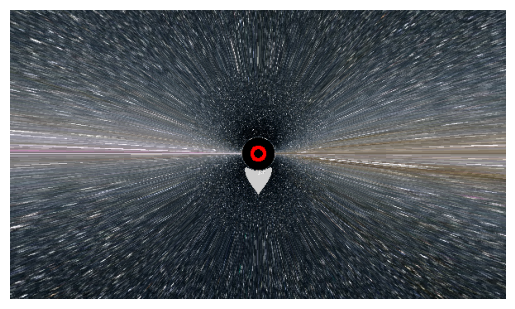

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
from PIL import Image
from scipy import optimize
from scipy.special import ellipkinc
from scipy.optimize import fsolve

class SchwarzschildRayTracer:
    def __init__(self, bh_mass=1.0, image_size_x=700, image_size_y=700):

        self.image_size_x = image_size_x
        self.image_size_y = image_size_y

        self.bh_mass = bh_mass
        self.rs = 2 * bh_mass  # Radio de Schwarzschild
        self.r_start = 100 * self.rs
        self.b_max_x = 40*self.rs
        self.b_max_y = self.b_max_x/image_size_x*image_size_y
        self.b_max = np.sqrt(self.b_max_x**2+self.b_max_y**2)
        self.r_max = self.r_start*1.1
        self.image = np.zeros((image_size_y, image_size_x, 3), dtype=np.uint8)  # RGB
        
        self.stars_img = np.array(Image.open("../data/Background_1.jpg").convert('RGB'))

        self.stars_height, self.stars_width = self.stars_img.shape[:2]
        print(self.stars_height, self.stars_width)

    def equation(self, phi, y, b):
        # y = [r, dr/dphi]
        r, dr_dphi = y
        f = 1 - self.rs / r
        d2r_dphi2 = (f * (self.r_start**2 / b**2) - f * (dr_dphi**2) / r - f * r)
        return [dr_dphi, d2r_dphi2]
    
    def trace_ray(self, b, theta_view):
        phi= np.arcsin(b / np.sqrt(b**2+self.r_start**2))    #[0,pi]
        #phi_max= np.arcsin(self.b_max / np.sqrt(self.b_max**2+self.r_start**2))

        def cartesian_to_spherical(x, y, z):
            r = np.sqrt(x**2 + y**2 + z**2)
            theta = np.arccos(z / r)        # colatitud [0, π]
            phi = np.arctan2(y, x)          # longitud [-π, π]
            return r, theta, phi

        def spherical_to_mollweide(theta, phi):
            # Convert colatitude to latitude
            lat = np.pi/2 - theta  # [−π/2, π/2]

            # Mollweide projection parameters
            def equation(theta_p):
                return 2 * theta_p + np.sin(2 * theta_p) - np.pi * np.sin(lat)

            theta_p_initial_guess = lat
            theta_p = fsolve(equation, theta_p_initial_guess)[0]

            x = 0.999 / np.pi * phi * np.cos(theta_p)+0.5
            y = 0.999 * np.sin(theta_p)+0.5
            return x, y
        
        def colour(phi, theta_view, alpha):
            #phi = (phi-phi_max/2) #[-pi/20,pi/20]

            x = (np.sin(phi+alpha) * np.cos(theta_view)) #[-1,1]
            y = (np.sin(phi+alpha) * np.sin(theta_view)) #[-1,1]
            z = np.cos((phi+alpha)) #[-1,1]

            #_, theta1, phi1=cartesian_to_spherical(x, y, z)
            #x,y=spherical_to_mollweide(theta1, phi1)

            x= (0.9*np.arctan2(-x,y)+ np.pi)/2/np.pi
            y=0.49*y+0.5

            i = int(x * self.stars_width) % self.stars_width #[0, 1, ..., self.stars_width]
            j = int(y * self.stars_height) % self.stars_height

            return self.stars_img[j, i]
            
        def f_rm(b):
            def rmin(R, b):
                return 1 / b**2 - 1 / R**2 + self.rs / R**3
            
            r_min = self.rs * 3/2
            r_max = self.r_max
            fa = rmin(r_min, b)
            fb = rmin(r_max, b)

            if fa * fb >= 0:
                return 0
            else:
                sol = optimize.root_scalar(rmin, bracket=[r_min, r_max], args=(b,), method='brentq')
                rm = sol.root
                return rm

        def deflexion(rm):
            s=np.sqrt((rm-self.rs)*(rm+3*self.rs))
            m=(s-rm+3*self.rs)/2/s
            arg=np.sqrt(2*s/(3*rm-3*self.rs+s))
            arg = np.clip(arg, -1.0, 1.0)
            varphi=np.arcsin(arg)

            alpha=(4*np.sqrt(rm/s)*float(ellipkinc(varphi, m)) % (2 * np.pi) ) -np.pi  #[-pi, pi]
            return alpha
        
        if b<=1.001*self.rs:
            return [0, 0, 0]  # Evitar errores numericos de division por 0 y es evidente que caen al agujero. 
        
        rm=f_rm(b)
        alpha = deflexion(rm)
        #alpha=0
        if np.isnan(alpha):
            return [0,0,0]
        else:
            return colour(phi, theta_view, alpha)


    def render(self):
        
        b_max_x = self.b_max_x
        b_max_y = self.b_max_y
        d=np.sqrt(self.image_size_x**2/self.image_size_y**2+1)
        with tqdm(total=self.image_size_y, desc="Renderizando", unit="px") as pbar:

            for i in range(self.image_size_y):
                for j in range(self.image_size_x):

                    x = (j - self.image_size_x / 2) / (self.image_size_x / 2) * b_max_x
                    y = (i - self.image_size_y / 2) / (self.image_size_y / 2) * b_max_y
                    
                    theta_view = np.arctan2(y, x)
                    b = np.sqrt(x**2 + y**2)

                    A= ((self.rs*np.cos(theta_view) - 2 * b_max_x / (self.image_size_x / 2) < x) and (x<self.rs*np.cos(theta_view) + 2 * b_max_x / (self.image_size_x / 2) ))
                    B= ((self.rs*np.sin(theta_view) - 2 * b_max_y / (self.image_size_y / 2) < y) and (y<self.rs*np.sin(theta_view) + 2 * b_max_y / (self.image_size_y / 2) ))

                    if A and B :
                        self.image[i, j] = [255,0,0]
                        #print("red")
                    else:
                        theta_view = np.arctan2(y, x)
                        color = self.trace_ray(b, theta_view)
                        self.image[i, j] = color
                pbar.update(1)


        plt.imshow(self.image, cmap='gray', origin='lower')
        #plt.title("Sombra del agujero negro (modelo simple)")
        plt.axis('off')
        #plt.show()
        plt.savefig("../Multimedia/Agujero_negro/Sombra del agujero negro.png")

rt = SchwarzschildRayTracer(image_size_x=600, image_size_y=350, bh_mass=1.0)
rt.render() # máximo parámetro de impacto

